In [79]:
import pandas as pd 
import os 
from scipy import spatial
import langdetect
import numpy as np 
import os 


In [80]:
df = pd.read_csv("../../data/translation/df_translated_with_tests.csv")

/var/folders/x7/f5pbgh4x4wg5wy434tcjgcc40000gn/T/ipykernel_66348/956678468.py:1: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../data/translation/df_translated_with_tests.csv")


In [81]:
tested = df[~(df["translationTest"].isna())]
non_matched = tested[~(tested["translatedText"] == tested["translationTest"])]
print("verbatim matches:", len(tested) - len(non_matched), f"({(len(tested)-len(non_matched)) / len(tested)})")

verbatim matches: 454 (0.227)


In [82]:
non_matched.to_csv("../../data/translation/df_non_matched.csv", index=False)

In [83]:
del df

## Testing whether Gemini accurately detected English language

In [84]:
# using 
baseline_en = tested["text"].map(langdetect.detect) == "en"
gemini_en = tested["translationTestSource"] == "original_gm"
parllaw_en = tested["translationSource"] == "original_pl"

In [90]:
language_non_matched = sum(~(gemini_en == parllaw_en)) 
parllaw_correct = sum(baseline_en == parllaw_en)
gemini_correct = sum(baseline_en == gemini_en)

print("% disagreement parllaw and gemini", language_non_matched, f"({language_non_matched/ len(tested)})")
print("% correct parllaw", parllaw_correct, f"({parllaw_correct/ len(tested)})")
print("% correct gemini", gemini_correct, f"({gemini_correct/ len(tested)})")

% disagreement parllaw and gemini 391 (0.1955)
% correct parllaw 1984 (0.992)
% correct gemini 1607 (0.8035)


Hmm, thats not great... I looked at some examples where Gemini was wrong and it seems like it handled the cases where the original language was still included in a tag e.g. "(DE) this is the speech"

In [92]:
# false positives: 
print("Gemini false positives (eng when was not actually eng)", sum((gemini_en == True) & (baseline_en == False)) / len(tested))
print("Gemini false negatives (not eng when was not actually eng)", sum((gemini_en == False) & (baseline_en == True)), f"({sum((gemini_en == False) & (baseline_en == True)) / len(tested)})")

Gemini false positives (eng when was not actually eng) 0.0
Gemini false negatives (not eng when was not actually eng) 393 (0.1965)


Okay thats nice, so it only was too generous by re-translating text that was already in English. Confirming this by testing whether its mistakes were made primarily when the text was of a pattern "(XX) ...", indicating that the language tag XX was before the acutal speech

In [87]:
import re

pattern = re.compile(r"^\(.{2}\)\s")
contains_langflag = (tested["text"].map(lambda s: bool(pattern.match(s))))

print("N of those who did not start with (XX):")
print("Gemini english detection accuracy with language flag present:", sum(baseline_en[contains_langflag] == gemini_en[contains_langflag]) / len(baseline_en[contains_langflag]))
print("Gemini english detection accuracy without language flag present:", sum(baseline_en[~contains_langflag] == gemini_en[~contains_langflag]) / len(baseline_en[~contains_langflag]))

N of those who did not start with (XX):
Gemini english detection accuracy with language flag present: 0.3723916532905297
Gemini english detection accuracy without language flag present: 0.9985475671750181


phew... so Gemini itself is reliable, we should have just removed the language tags before translating...

## Comparing translation embeddings to make sure they are comparable to the original and parllaw translation

In [88]:
# run on colab: 
# import os 
# model_ids = [
#     "jinaai/jina-embeddings-v4",
#   ]


# for model_id in model_ids:
#   model = AutoModel.from_pretrained(model_id, trust_remote_code=True, torch_dtype="auto").to(device)
#   modelname = model_id.split("/")[-1]
#   os.makedirs(modelname, exist_ok=True)
#   for column in ["text", "translatedText", "translationTest"]:
#     embedd_speech(model, non_matched, column, f"{modelname}/embedding_{column}.npy")


English texts: <= texts that where in English according to parllaw, but gemini's response was not the verbatim speech
original ~ parllaw 0.999686
original ~ gemini 0.99542874
gemini ~ parllaw 0.9955103

Non-english texts: <= texts that where not in English according to parllaw
original ~ parllaw 0.9461046
original ~ gemini 0.9433505
gemini ~ parllaw 0.9885919 (std: 0.008730310946702957)
Showing least examples with least similarity (parllaw ~ gemini)
Avg. cosine similarity of gemini and parllaw translation is with prob. 0.95 greater 0.9881118489651224 (N: 1001)


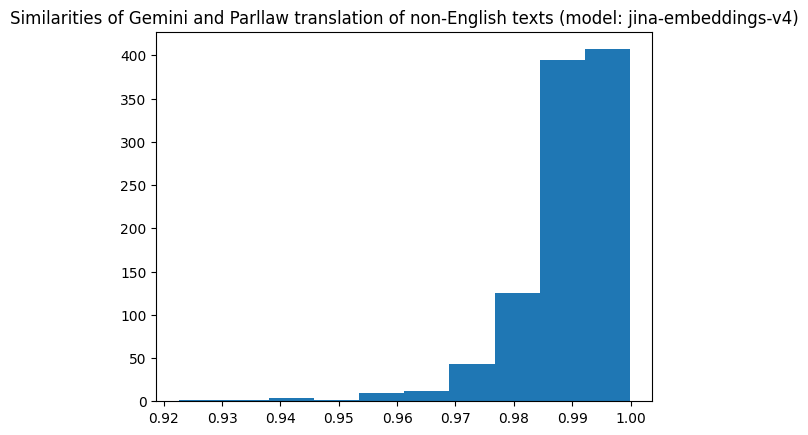

In [163]:
import matplotlib.pyplot as plt
from scipy.stats import bootstrap, permutation_test


for rooth, dirs, files in os.walk("../../data/embeddings/translation_test"):
    for modelname in dirs:
        embedding_og = np.load(open(f"../../data/embeddings/translation_test/{modelname}/embedding_text.npy", "rb"))
        embedding_translated_pl = np.load(open(f"../../data/embeddings/translation_test/{modelname}/embedding_translatedText.npy", "rb"))
        embedding_translated_gm = np.load(open(f"../../data/embeddings/translation_test/{modelname}/embedding_translationTest.npy", "rb"))

        indices_english = non_matched["translationSource"] == "original_pl"

        def sim(m1, m2):
            return np.diag(m1 @ m2.T)

        # first compute embedding similarity of texts that were in english already (but not matched word to word)
        # - e.g. Gemini did not respond with "the text is in English" but repeated it verbatim and removed some comments:
        similarity_eng_og_pl = sim(embedding_og[indices_english], embedding_translated_pl[indices_english])
        similarity_eng_og_gm = sim(embedding_og[indices_english], embedding_translated_gm[indices_english])
        similarity_eng_gm_pl = sim(embedding_translated_gm[indices_english], embedding_translated_pl[indices_english])
        print("English texts: <= texts that where in English according to parllaw, but gemini's response was not the verbatim speech")
        print("original ~ parllaw", similarity_eng_og_pl.mean())
        print("original ~ gemini", similarity_eng_og_gm.mean())
        print("gemini ~ parllaw", similarity_eng_gm_pl.mean())

        # now similarity of non-english texts:
        similarity_non_eng_og_pl = sim(embedding_og[~indices_english], embedding_translated_pl[~indices_english])
        similarity_non_eng_og_gm = sim(embedding_og[~indices_english], embedding_translated_gm[~indices_english])
        similarity_non_eng_gm_pl = sim(embedding_translated_gm[~indices_english], embedding_translated_pl[~indices_english])
        print("\nNon-english texts: <= texts that where not in English according to parllaw")
        print("original ~ parllaw", similarity_non_eng_og_pl.mean())
        print("original ~ gemini", similarity_non_eng_og_gm.mean())
        print("gemini ~ parllaw", similarity_non_eng_gm_pl.mean(), f"(std: {similarity_non_eng_gm_pl.std()})")

        sort_indices = np.argsort(similarity_non_eng_gm_pl)

        print("Showing least examples with least similarity (parllaw ~ gemini)")
        n_examples = 5
        worst_sim_examples = non_matched[~indices_english].iloc[sort_indices[:n_examples]]
        worst_sims = similarity_non_eng_gm_pl[sort_indices[:n_examples]]

        # for (i, ex), sim in zip(worst_sim_examples.iterrows(), worst_sims):
        #     print("\nSimilarity (gemini & parllaw translation):", sim)
        #     print("original:", ex["text"])
        #     print("parllaw:", ex["translatedText"])
        #     print("gemini:", ex["translationTest"])

        plt.hist(similarity_non_eng_gm_pl)
        plt.title(f"Similarities of Gemini and Parllaw translation of non-English texts (model: {modelname})")

        # To test whether the translations can be used interchangably, compute TOST:
        # We have estimator for distances: 1 - similarity of translation1 and translation2
        # Want to make sure that with high confidence, the distance is in a range of [0, 0.05]
        # => mean_dist


        ci = bootstrap((similarity_non_eng_gm_pl,), np.mean, alternative="greater")
        print("Avg. cosine similarity of gemini and parllaw translation is with prob. 0.95 greater", ci.confidence_interval.low, f"(N: {len(similarity_non_eng_gm_pl)})")
    
        # just to make completely sure (and because it is good practice:
        # permutation test by randomly swapping labels of gemini and parllaw translation and comparing similarity to original speech 
        # testing whether they can be distinguished
        # p_permutation = permutation_test([similarity_non_eng_og_pl, similarity_non_eng_og_gm], (lambda x,y,axis : np.mean(x, axis=axis) - np.mean(y, axis=axis)))
        # print(p_permutation.statistic)
        # plt.figure()
        # plt.hist(p_permutation.null_distribution)
        # plt.axvline(p_permutation.statistic, color="red")
        # plt.show()
        # print("Gemini's and Parllaw's similarities to the original dataset come from the same distribution with probability", p_permutation.pvalue)

=> gemini translations are very comparable to parllaw's machine translations (avg. similarity for jina-v4 embeddings roughly 0.99)